## Import & Process Image

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg16 import VGG16

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, f1_score
from sklearn.metrics import precision_recall_curve, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import glob

from src.functions import *

AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

pd.options.display.max_columns = 100

## Pipeline with Sample Dataset (Balanced dataset)

In [2]:
X = np.load('data_sample/sample_100x100.npy')
y = np.load('data_sample/sample_diagnosis.npy')

In [3]:
# Train/test split for Train Set
XX_train, X_test, yy_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(XX_train, yy_train, test_size=0.2, random_state=42, stratify=yy_train)

#### Train Model

In [4]:
## Import Model
model = VGG16(include_top=False, input_shape=(100, 100, 3))

## Transfer Learning
new_model = Sequential()
for layer in model.layers[:-2]: # just exclude the last two FC layers
    layer.trainable = False
    new_model.add(layer)
new_model.add(Conv2D(512, (5, 5), activation = 'relu', padding = 'same'))
new_model.add(MaxPooling2D(2,2))
new_model.add(Flatten())
new_model.add(Dense(128, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(1, activation ='sigmoid'))

58892288/58889256 [==============================] - 1s 0us/step


In [5]:
opt = keras.optimizers.SGD(learning_rate=0.01)
new_model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [6]:
history = new_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
20/20 [==============================] - 14s 719ms/step - loss: 0.6057 - accuracy: 0.6677 - recall: 0.6594 - val_loss: 0.5631 - val_accuracy: 0.6850 - val_recall: 0.4200
Epoch 2/20
20/20 [==============================] - 14s 701ms/step - loss: 0.5117 - accuracy: 0.7367 - recall: 0.7250 - val_loss: 0.4780 - val_accuracy: 0.7550 - val_recall: 0.6300
Epoch 3/20
20/20 [==============================] - 14s 692ms/step - loss: 0.4407 - accuracy: 0.7931 - recall: 0.7781 - val_loss: 0.5207 - val_accuracy: 0.7250 - val_recall: 0.5100
Epoch 4/20
20/20 [==============================] - 14s 691ms/step - loss: 0.4194 - accuracy: 0.8119 - recall: 0.8000 - val_loss: 0.4887 - val_accuracy: 0.7500 - val_recall: 0.5800
Epoch 5/20
20/20 [==============================] - 14s 680ms/step - loss: 0.4108 - accuracy: 0.8088 - recall: 0.8094 - val_loss: 0.5048 - val_accuracy: 0.7350 - val_recall: 0.5500
Epoch 6/20
20/20 [==============================] - 13s 672ms/step - loss: 0.3809 - accuracy: 0

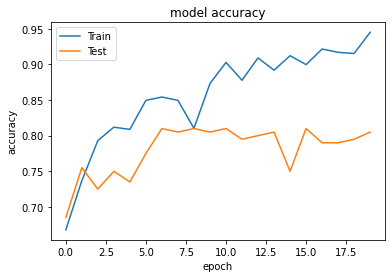

In [7]:
plot_accuracy(history)

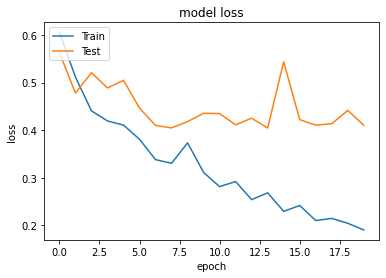

In [8]:
plot_loss(history)

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])

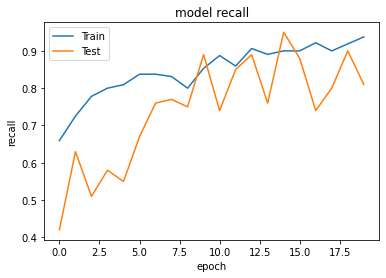

In [10]:
plot_recall(history, 'recall')

## Evalaution

### ROC AUC

In [11]:
# Predictions for Validation Set
y_val_pred = new_model.predict(X_val)

In [12]:
# Predictions for Test Set
y_test_pred = new_model.predict(X_test)

In [13]:
fpr, tpr, thres_roc = roc_curve(y_test, y_test_pred)
auc_keras = auc(fpr, tpr)

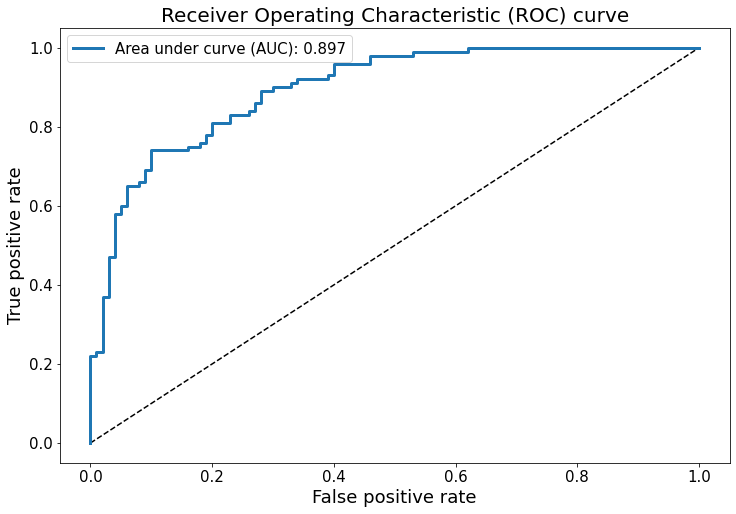

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
ticks = np.arange(-0.2 ,1.2 , 0.2)

title_size = 20
label_size = 18
legend_size = 15
tick_size = 15

ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr, label='Area under curve (AUC): {:.3f}'.format(auc_keras), linewidth=3.0)

ax.set_title('Receiver Operating Characteristic (ROC) curve', size=title_size)

ax.set_xlabel('False positive rate', size=label_size)
ax.set_ylabel('True positive rate', size=label_size)

ax.set_xticklabels(ticks, fontsize=tick_size)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.set_yticklabels(ticks, fontsize=tick_size)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.legend(loc='best', fontsize=legend_size)
fig.show()

### Precision Recall Curve

In [15]:
precision, recall, thresh_pr_curve = precision_recall_curve(y_test, y_test_pred)

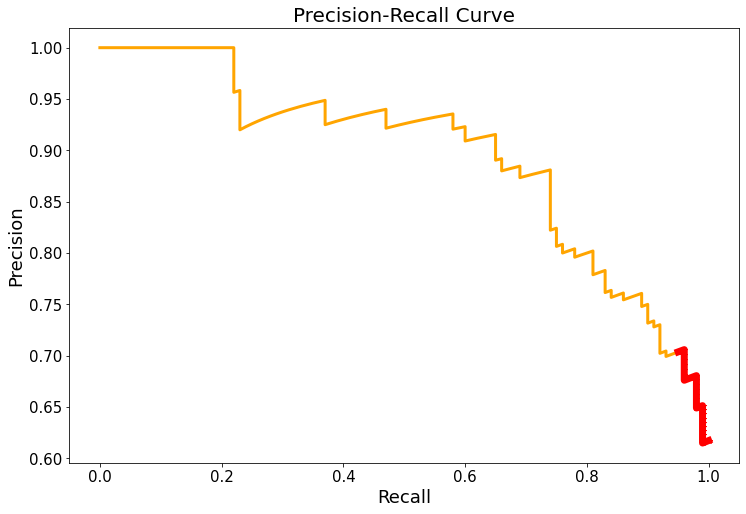

In [47]:
fig, ax = plt.subplots(figsize=(12,8))
ticks = np.arange(-0.2 ,1.2 , 0.2)

title_size = 20
label_size = 18
legend_size = 15
tick_size = 15
thresh_loc = len(recall[recall>=0.95])

ax.plot(recall, precision, color='orange', linewidth=3.0)
ax.plot(recall[:thresh_loc], precision[:thresh_loc], marker='*', color='red', linewidth=7.0)

ax.set_title('Precision-Recall Curve', size=title_size)

ax.set_xticklabels(ticks, fontsize=tick_size)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax.set_yticklabels(ticks, fontsize=tick_size)
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.set_xlabel('Recall', size=label_size)
ax.set_ylabel('Precision', size=label_size)

fig.show()

In [19]:
# The most liberal threshold given that recall >= 95%
liberal_thresh = thresh_pr_curve[:thresh_loc][-1]
liberal_thresh

0.2033729

In [21]:
# F1 scores for all thresholds
f1_all = [f1_score(y_test, y_test_pred >= i) for i in thresh_pr_curve]
# F1 scores when recall >= 95%
f1_lst = [f1_score(y_test, y_test_pred >= i) for i in thresh_pr_curve[:thresh_loc]]
# Index of highest F1 score when recall >= 95%
max_index_col = np.argmax(f1_lst, axis=0)

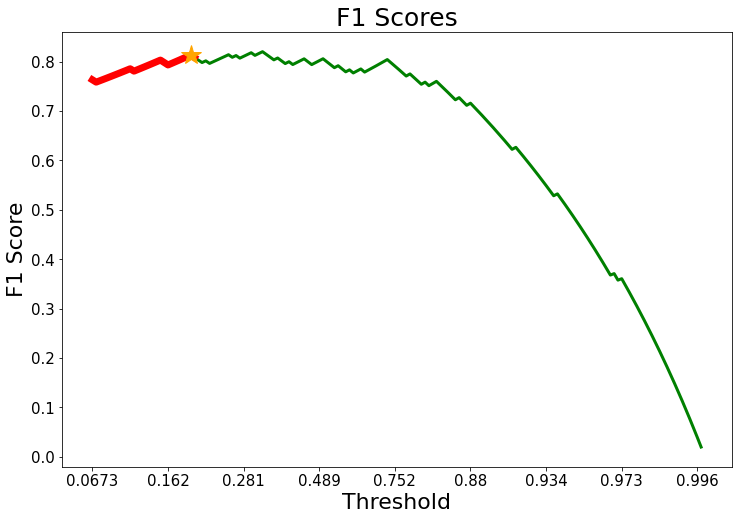

In [37]:
fig, ax = plt.subplots(figsize=(12,8))

xticks = [0.0673, 0.162, 0.281, 0.489, 0.752, 0.880, 0.934, 0.973, 0.996]
yticks = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8]
f1_x = np.arange(len(f1_lst))
f1_xx = np.arange(len(f1_all))

title_size = 25
label_size = 22
legend_size = 15
tick_size = 15

ax.plot(f1_xx, f1_all, color='green', linewidth=3.0)
ax.plot(f1_x, f1_lst, color='red', linewidth=7.0)

ax.plot(f1_xx[max_index_col], f1_all[max_index_col], 
        marker='*', markersize=20, color='orange')

ax.set_title('F1 Scores', size=title_size)

ax.set_xticks([0,20,40,60,80,100,120,140,160])
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
ax.set_xticklabels(xticks, fontsize=tick_size)
ax.set_yticklabels(yticks, fontsize=tick_size)

ax.set_xlabel('Threshold', size=label_size)
ax.set_ylabel('F1 Score', size=label_size)

fig.show()

In [38]:
# The highest F1 score threshold given that recall >= 95%.
final_thresh = thresh_pr_curve[max_index_col]
final_thresh

0.20002231

### Confusion Matrix

In [39]:
from src.functions import matrix_score

#### Validation Set

In [40]:
matrix_score(y_val, y_val_pred >= final_thresh)

[[74  6]
 [28 52]]
Recall:    0.925
Precision: 0.725
Accuracy:  0.787
ROC AUC:   0.787


In [41]:
f1_score(y_val, y_val_pred>=final_thresh)

0.8131868131868133

#### Test Set

In [42]:
matrix_score(y_test, y_test_pred >= final_thresh)

[[96  4]
 [40 60]]
Recall:    0.960
Precision: 0.706
Accuracy:  0.780
ROC AUC:   0.780


In [43]:
f1_score(y_test, y_test_pred>=final_thresh)

0.8135593220338982

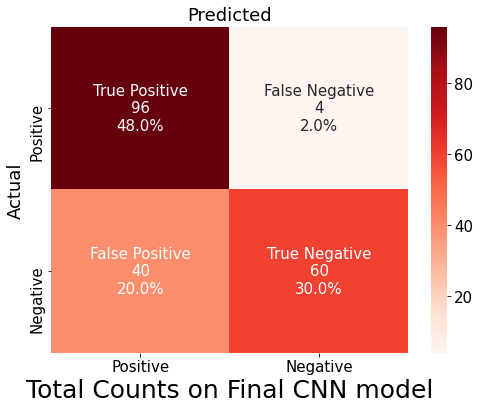

In [44]:
plt.rcParams.update({'font.size': 15})
title=25
tick = 14
label= 18

class_labels = ['Positive', 'Negative']
cm = confusion_matrix(y_test,(y_test_pred >= final_thresh).astype(int),normalize=None)
tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
cm = np.array([[tp, fn], [fp, tn]])

group_names = ['True Positive','False Negative','False Positive','True Negative']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.1%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm,cmap='Reds', annot=labels, fmt='', ax=ax,xticklabels=class_labels, yticklabels=class_labels)

ax.set_title('Predicted', size=label)
ax.set_xlabel('Total Counts on Final CNN model', size=title)
ax.set_ylabel('Actual', size=label)
fig.show()